In [1]:
import sunpy.map
from sunpy.net import scraper
from astropy import units as u
from sunpy.time import TimeRange
import parfive
import glob
import matplotlib.pyplot as plt
import pandas as pd
from stixdcpy.net import Request as jreq
import numpy as np
from matplotlib.colors import Normalize, LogNorm

## Get STIX Flare times

In [4]:
flares=jreq.fetch_flare_list('2022-11-09T00:00:00', '2023-01-10T20:00:00')
flare_df = pd.DataFrame(flares)

In [5]:
new_df = flare_df[flare_df['LC1_PEAK_COUNTS_4S'] > 10**3]

In [6]:
new_df.sort_values('LC1_PEAK_COUNTS_4S', ascending=False)

,flare_id,duration,att_in,peak_UTC,LC0_BKG,_id,GOES_class,GOES_flux,CFL_X_arcsec,CFL_Y_arcsec,...,LC0_PEAK_COUNTS_4S,LC0_BKG_COUNTS_4S,LC1_PEAK_COUNTS_4S,LC1_BKG_COUNTS_4S,LC2_PEAK_COUNTS_4S,LC2_BKG_COUNTS_4S,LC3_PEAK_COUNTS_4S,LC3_BKG_COUNTS_4S,LC4_PEAK_COUNTS_4S,LC4_BKG_COUNTS_4S
75,2301091852,3800,True,2023-01-09T18:52:44.298,250.049350,21362,X2.0,0.000198,None,None,...,1507327,247.0,278527,45.0,47103,57.0,4863,735.0,1983,399.0
445,2301030625,940,True,2023-01-03T06:25:24.620,237.591938,20983,C2.7,0.000003,None,None,...,1376255,271.0,278527,45.0,77823,57.0,23551,735.0,5375,399.0
799,2212270729,4332,False,2022-12-27T07:29:00.378,334.494533,20630,M1.1,0.000011,None,None,...,1114111,271.0,221183,45.0,34815,57.0,1343,735.0,463,399.0
304,2301060056,4388,False,2023-01-06T00:56:39.935,223.000000,21115,X1.2,0.000122,None,None,...,1245183,231.0,204799,45.0,38911,57.0,10751,735.0,2431,399.0
444,2301030642,180,True,2023-01-03T06:42:20.622,237.591938,20984,C3.2,0.000003,None,None,...,1638399,271.0,188415,45.0,17407,57.0,863,735.0,431,399.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,2301101244,916,False,2023-01-10T12:44:40.410,323.964470,21414,C5.4,0.000005,None,None,...,14847,247.0,1087,45.0,183,57.0,799,735.0,463,399.0
953,2212242204,6084,False,2022-12-24T22:04:28.519,222.359306,20476,C1.5,0.000001,None,None,...,15871,231.0,1087,45.0,115,57.0,799,735.0,463,399.0
1335,2212171733,1624,False,2022-12-17T17:33:16.143,226.219630,20094,C5.1,0.000005,None,None,...,15871,247.0,1087,45.0,231,57.0,799,735.0,463,399.0
2714,2211160532,2516,False,2022-11-16T05:32:36.101,236.314329,18715,C3.4,0.000003,None,None,...,13823,271.0,1087,45.0,199,57.0,863,735.0,431,399.0


## Code to fetch EUI short exposure files

In [99]:
def get_eui_filelist(timerange):
    """
    Function to list all available EUI-HRI files from SIDC
    
    Parameters
    ----------
    timerange : `sunpy.time.TimeRange`
        timerange of interest
        
    Returns
    -------
    `list` of files
    """
    eui_pattern = ("https://www.sidc.be/EUI/data/{level}/%Y/%m/%d/"
                   "solo_{level}_eui-{descriptor}_%Y%m%dT%H%M%S.*\.fits")

    eui_scraper = scraper.Scraper(eui_pattern, level="L2", descriptor='fsi174-image-short')
    eui_file_urls = eui_scraper.filelist(timerange)
    return eui_file_urls

def fetch_eui_files(eui_file_urls, timerange):
    """
    Download the EUI url files passed. Downloads them to a folder named based on timerange.
    
    Parameters
    ----------
    eui_file_urls: `list`
        list of EUI file urls
    timerange : `sunpy.time.TimeRange`
        timerange of files (for file naming) 

    Returns
    -------
    parfive results object with local file paths
    """
    downloader = parfive.Downloader()
    
    for f in eui_file_urls:
        downloader.enqueue_file(f, path="./eui_files")
    
    files = downloader.download()  
    return files

In [69]:
eui_file_urls = []
for i in range(len(new_df)):
    print(i)
    start_time  = np.asarray(new_df['start_UTC'])[i]
    end_time  = np.asarray(new_df['end_UTC'])[i]
    timerange = TimeRange(start_time, end_time)
    eui_file_urls.append(get_eui_filelist(timerange))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204


In [75]:
no_eui_files = [len(eui_file_urls[i]) for i in range(len(eui_file_urls))]

In [77]:
new_df['No EUI files'] = no_eui_files

/var/folders/l6/88j7fvx51715f93rw6wngs_m0000gn/T/ipykernel_91989/644815479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['No EUI files'] = no_eui_files


In [107]:
new_df

,flare_id,duration,att_in,peak_UTC,LC0_BKG,_id,GOES_class,GOES_flux,CFL_X_arcsec,CFL_Y_arcsec,...,LC0_BKG_COUNTS_4S,LC1_PEAK_COUNTS_4S,LC1_BKG_COUNTS_4S,LC2_PEAK_COUNTS_4S,LC2_BKG_COUNTS_4S,LC3_PEAK_COUNTS_4S,LC3_BKG_COUNTS_4S,LC4_PEAK_COUNTS_4S,LC4_BKG_COUNTS_4S,No EUI files
9,2301101748,648,False,2023-01-10T17:48:12.442,323.964470,21428,M1.3,0.000013,None,None,...,247.0,10751,45.0,2687,57.0,1215,735.0,463,399.0,0
11,2301101726,1248,False,2023-01-10T17:26:16.439,323.964470,21426,M1.4,0.000014,None,None,...,247.0,11775,45.0,1087,57.0,799,735.0,431,399.0,0
16,2301101447,2704,False,2023-01-10T14:47:04.423,323.964470,21421,C8.7,0.000009,None,None,...,247.0,3967,45.0,991,57.0,1087,735.0,431,399.0,2
19,2301101358,1736,False,2023-01-10T13:58:32.418,323.964470,21418,C6.8,0.000007,None,None,...,247.0,1599,45.0,167,57.0,799,735.0,463,399.0,5
23,2301101244,916,False,2023-01-10T12:44:40.410,323.964470,21414,C5.4,0.000005,None,None,...,247.0,1087,45.0,183,57.0,799,735.0,463,399.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,2211110709,2380,False,2022-11-11T07:09:24.047,228.936588,18385,M1.2,0.000012,None,None,...,247.0,15871,45.0,3199,57.0,1343,735.0,463,399.0,5
3049,2211110552,1680,False,2022-11-11T05:52:08.039,228.936588,18379,C2.0,0.000002,None,None,...,247.0,1727,45.0,863,57.0,1087,735.0,463,399.0,0
3055,2211110437,1708,False,2022-11-11T04:37:16.031,228.936588,18374,C3.3,0.000003,None,None,...,247.0,3455,45.0,991,57.0,1087,735.0,463,399.0,0
3058,2211110313,3772,False,2022-11-11T03:13:36.122,228.936588,18371,C2.5,0.000003,None,None,...,247.0,6399,45.0,4351,57.0,2687,735.0,863,399.0,0


In [79]:
new_df.sort_values('LC1_PEAK_COUNTS_4S', ascending=False)

,flare_id,duration,att_in,peak_UTC,LC0_BKG,_id,GOES_class,GOES_flux,CFL_X_arcsec,CFL_Y_arcsec,...,LC0_BKG_COUNTS_4S,LC1_PEAK_COUNTS_4S,LC1_BKG_COUNTS_4S,LC2_PEAK_COUNTS_4S,LC2_BKG_COUNTS_4S,LC3_PEAK_COUNTS_4S,LC3_BKG_COUNTS_4S,LC4_PEAK_COUNTS_4S,LC4_BKG_COUNTS_4S,No EUI files
75,2301091852,3800,True,2023-01-09T18:52:44.298,250.049350,21362,X2.0,0.000198,None,None,...,247.0,278527,45.0,47103,57.0,4863,735.0,1983,399.0,11
445,2301030625,940,True,2023-01-03T06:25:24.620,237.591938,20983,C2.7,0.000003,None,None,...,271.0,278527,45.0,77823,57.0,23551,735.0,5375,399.0,0
799,2212270729,4332,False,2022-12-27T07:29:00.378,334.494533,20630,M1.1,0.000011,None,None,...,271.0,221183,45.0,34815,57.0,1343,735.0,463,399.0,0
304,2301060056,4388,False,2023-01-06T00:56:39.935,223.000000,21115,X1.2,0.000122,None,None,...,231.0,204799,45.0,38911,57.0,10751,735.0,2431,399.0,12
444,2301030642,180,True,2023-01-03T06:42:20.622,237.591938,20984,C3.2,0.000003,None,None,...,271.0,188415,45.0,17407,57.0,863,735.0,431,399.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,2301101244,916,False,2023-01-10T12:44:40.410,323.964470,21414,C5.4,0.000005,None,None,...,247.0,1087,45.0,183,57.0,799,735.0,463,399.0,3
953,2212242204,6084,False,2022-12-24T22:04:28.519,222.359306,20476,C1.5,0.000001,None,None,...,231.0,1087,45.0,115,57.0,799,735.0,463,399.0,0
1335,2212171733,1624,False,2022-12-17T17:33:16.143,226.219630,20094,C5.1,0.000005,None,None,...,247.0,1087,45.0,231,57.0,799,735.0,463,399.0,0
2714,2211160532,2516,False,2022-11-16T05:32:36.101,236.314329,18715,C3.4,0.000003,None,None,...,271.0,1087,45.0,199,57.0,863,735.0,431,399.0,7


In [80]:
many_eui_files = new_df[new_df['No EUI files'] > 10]

In [88]:
many_eui_files


,flare_id,duration,att_in,peak_UTC,LC0_BKG,_id,GOES_class,GOES_flux,CFL_X_arcsec,CFL_Y_arcsec,...,LC0_BKG_COUNTS_4S,LC1_PEAK_COUNTS_4S,LC1_BKG_COUNTS_4S,LC2_PEAK_COUNTS_4S,LC2_BKG_COUNTS_4S,LC3_PEAK_COUNTS_4S,LC3_BKG_COUNTS_4S,LC4_PEAK_COUNTS_4S,LC4_BKG_COUNTS_4S,No EUI files
37,2301100903,5396,True,2023-01-10T09:03:44.387,250.049350,21400,C8.8,0.000009,None,None,...,247.0,2687,45.0,367,57.0,863,735.0,463,399.0,15
56,2301100220,4132,True,2023-01-10T02:20:48.345,250.049350,21381,M2.7,0.000027,None,None,...,247.0,126975,45.0,17407,57.0,1343,735.0,543,399.0,12
75,2301091852,3800,True,2023-01-09T18:52:44.298,250.049350,21362,X2.0,0.000198,None,None,...,247.0,278527,45.0,47103,57.0,4863,735.0,1983,399.0,11
87,2301091457,4184,False,2023-01-09T14:57:48.274,247.629291,21350,C7.9,0.000008,None,None,...,247.0,2175,45.0,231,57.0,799,735.0,463,399.0,12
101,2301090859,5796,False,2023-01-09T08:59:32.237,230.416972,21336,M2.1,0.000021,None,None,...,247.0,9727,45.0,1343,57.0,863,735.0,463,399.0,16
121,2301090056,4000,False,2023-01-09T00:56:48.286,230.416972,21316,M1.1,0.000011,None,None,...,247.0,5887,45.0,607,57.0,799,735.0,463,399.0,11
148,2301081506,4244,False,2023-01-08T15:06:16.226,251.160232,21289,M1.4,0.000014,None,None,...,247.0,2943,45.0,271,57.0,799,735.0,463,399.0,12
162,2301080851,5056,False,2023-01-08T08:51:24.185,246.679290,21275,M1.4,0.000014,None,None,...,247.0,3967,45.0,431,57.0,799,735.0,463,399.0,14
202,2301071649,4104,False,2023-01-07T16:49:08.084,232.474200,21235,C8.7,0.000009,None,None,...,247.0,2943,45.0,303,57.0,799,735.0,463,399.0,12
217,2301071057,3740,False,2023-01-07T10:57:32.048,229.743805,21220,C7.0,0.000007,None,None,...,247.0,2687,45.0,399,57.0,799,735.0,431,399.0,11


In [91]:
M_class_eui_short = many_eui_files[many_eui_files['GOES_class'].str.contains('M')]

In [101]:
M_class_eui_short

,flare_id,duration,att_in,peak_UTC,LC0_BKG,_id,GOES_class,GOES_flux,CFL_X_arcsec,CFL_Y_arcsec,...,LC0_BKG_COUNTS_4S,LC1_PEAK_COUNTS_4S,LC1_BKG_COUNTS_4S,LC2_PEAK_COUNTS_4S,LC2_BKG_COUNTS_4S,LC3_PEAK_COUNTS_4S,LC3_BKG_COUNTS_4S,LC4_PEAK_COUNTS_4S,LC4_BKG_COUNTS_4S,No EUI files
56,2301100220,4132,True,2023-01-10T02:20:48.345,250.049350,21381,M2.7,0.000027,None,None,...,247.0,126975,45.0,17407,57.0,1343,735.0,543,399.0,12
101,2301090859,5796,False,2023-01-09T08:59:32.237,230.416972,21336,M2.1,0.000021,None,None,...,247.0,9727,45.0,1343,57.0,863,735.0,463,399.0,16
121,2301090056,4000,False,2023-01-09T00:56:48.286,230.416972,21316,M1.1,0.000011,None,None,...,247.0,5887,45.0,607,57.0,799,735.0,463,399.0,11
148,2301081506,4244,False,2023-01-08T15:06:16.226,251.160232,21289,M1.4,0.000014,None,None,...,247.0,2943,45.0,271,57.0,799,735.0,463,399.0,12
162,2301080851,5056,False,2023-01-08T08:51:24.185,246.679290,21275,M1.4,0.000014,None,None,...,247.0,3967,45.0,431,57.0,799,735.0,463,399.0,14
240,2301070049,4152,False,2023-01-07T00:49:44.084,229.743805,21197,M1.6,0.000016,None,None,...,247.0,14847,45.0,2687,57.0,927,735.0,463,399.0,11
2101,2212010718,5280,False,2022-12-01T07:18:16.372,220.117805,19327,M1.1,0.000011,None,None,...,247.0,4351,45.0,799,57.0,863,735.0,463,399.0,14
2545,2211191251,4912,False,2022-11-19T12:51:40.399,223.282003,18884,M1.6,0.000016,None,None,...,247.0,15871,45.0,1983,57.0,991,735.0,463,399.0,14


In [181]:
flare_M27_2301100220 = fetch_eui_files(eui_file_urls[8], timerange)

Files Downloaded:   0%|          | 0/12 [00:00<?, ?file/s]

solo_L2_eui-fsi174-image-short_20230110T022450174_V01.fits:   0%|          | 0.00/216k [00:00<?, ?B/s]

solo_L2_eui-fsi174-image-short_20230110T021850174_V01.fits:   0%|          | 0.00/216k [00:00<?, ?B/s]

solo_L2_eui-fsi174-image-short_20230110T021250173_V01.fits:   0%|          | 0.00/216k [00:00<?, ?B/s]

solo_L2_eui-fsi174-image-short_20230110T023650176_V01.fits:   0%|          | 0.00/219k [00:00<?, ?B/s]

solo_L2_eui-fsi174-image-short_20230110T023050175_V01.fits:   0%|          | 0.00/216k [00:00<?, ?B/s]

solo_L2_eui-fsi174-image-short_20230110T024250176_V01.fits:   0%|          | 0.00/216k [00:00<?, ?B/s]

solo_L2_eui-fsi174-image-short_20230110T024850177_V01.fits:   0%|          | 0.00/216k [00:00<?, ?B/s]

solo_L2_eui-fsi174-image-short_20230110T025450178_V01.fits:   0%|          | 0.00/216k [00:00<?, ?B/s]

solo_L2_eui-fsi174-image-short_20230110T030050178_V01.fits:   0%|          | 0.00/216k [00:00<?, ?B/s]

solo_L2_eui-fsi174-image-short_20230110T030650179_V01.fits:   0%|          | 0.00/219k [00:00<?, ?B/s]

solo_L2_eui-fsi174-image-short_20230110T031850180_V01.fits:   0%|          | 0.00/219k [00:00<?, ?B/s]

solo_L2_eui-fsi174-image-short_20230110T031250179_V01.fits:   0%|          | 0.00/216k [00:00<?, ?B/s]

In [210]:
filelist = glob.glob('eui_files/*.fits')

In [211]:
maps = sunpy.map.Map(filelist, sequence=True)

In [223]:
maps[1].exposure_time

<Quantity 0.2 s>

In [226]:
maps[1].max()

15385.1455

In [229]:
len(np.where(maps[1].data!=0)[0])

9322691

<IPython.core.display.Javascript object>


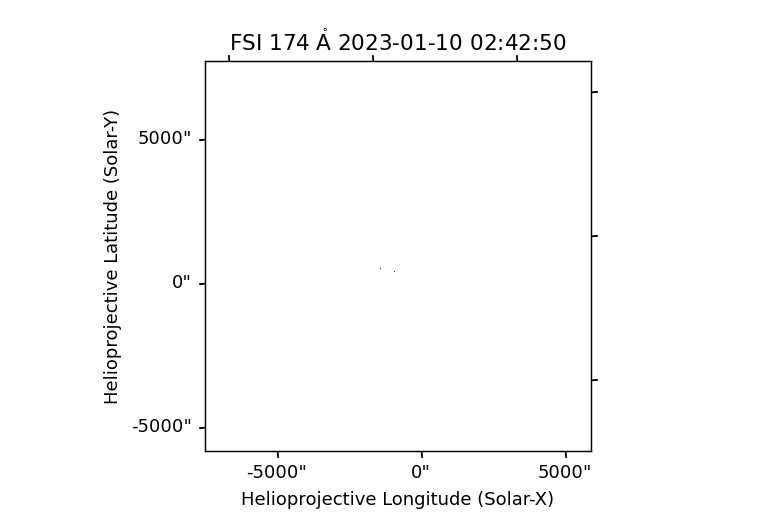

In [241]:
%matplotlib notebook
maps[5].plot(norm=Normalize())

In [231]:
normal_exp = sunpy.map.Map('/Users/hannahcollier/Documents/solo/data/eui/eui_gi_work_visit1/eui_gi_visit/notebooks/solo_L2_eui-fsi174-image_20230110T021855174_V01.fits')



<IPython.core.display.Javascript object>


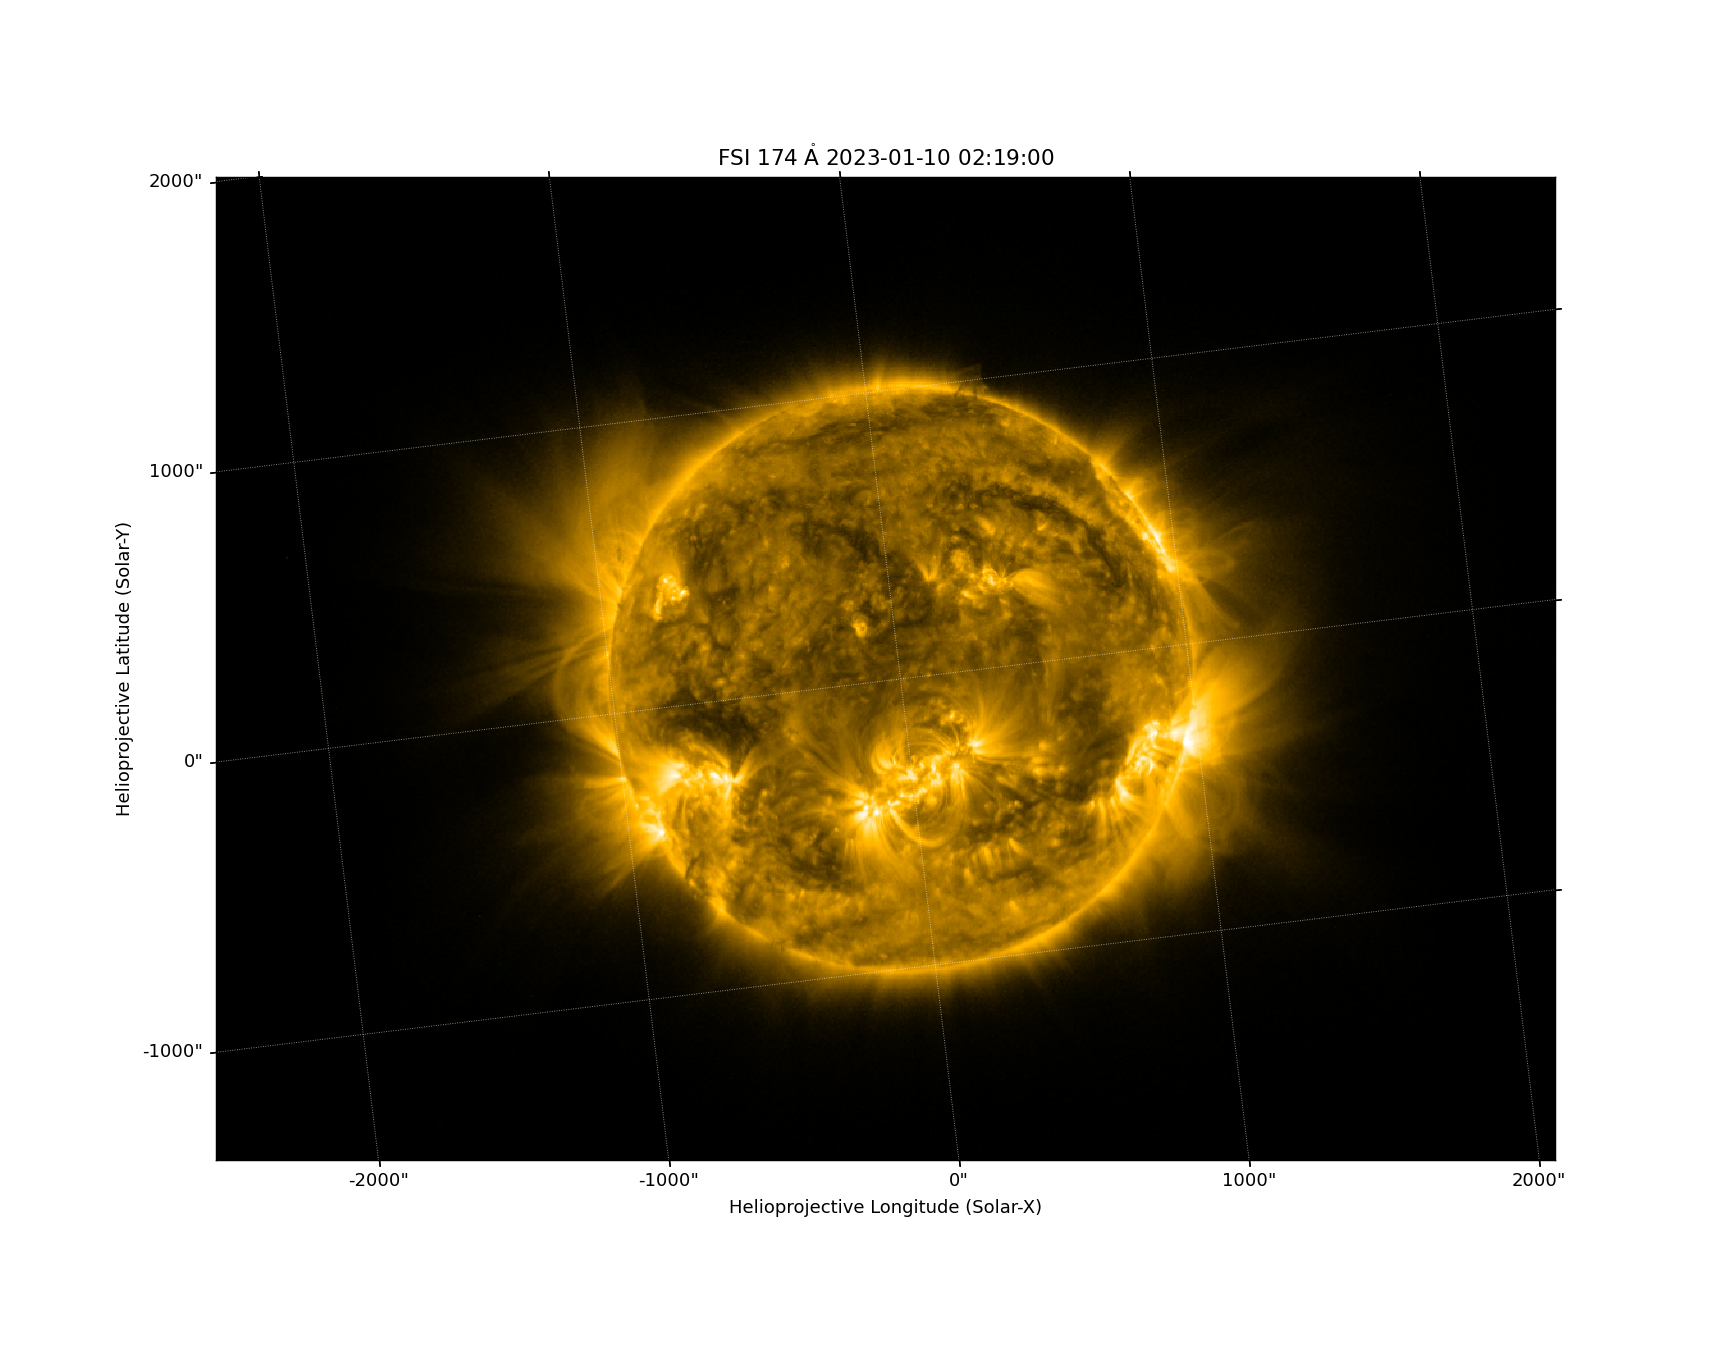

In [234]:
normal_exp.plot()

## Search all available data from the CSV file

In [25]:
eui_df = pd.read_csv("../eui_hri_list.csv")

In [26]:
eui_df.head()

,DATANAME,START DATE & TIME,END DATE & TIME,CADENCE (s),DISTANCE (AU),FILE #,SOOPNAME,080223_Updated_DayeLim
0,hrieuvopn,20220306T173446658,20220306T173458593,2,0.50,7,L_SMALL_HRES_HCAD_Slow-Wind-Connection;R_SMALL...,NaN
1,hrieuv174,20220307T002946572,20220307T002958508,2,0.50,7,R_BOTH_HRES_HCAD_Nanoflares,NaN
2,hrieuv174,20220307T003100224,20220307T020955227,5,0.50,1188,R_BOTH_HRES_HCAD_Nanoflares,NaN
3,hrieuv174,20220308T000003811,20220308T002921224,3,0.49,587,R_BOTH_HRES_HCAD_Nanoflares,NaN
4,hrieuvopn,20220308T003100231,20220308T020955233,5,0.49,1188,R_BOTH_HRES_HCAD_Nanoflares,NaN


In [27]:
eui_df["start_time"] = pd.to_datetime(eui_df["START DATE & TIME"], format="%Y%m%dT%H%M%S%f")
eui_df["end_time"] = pd.to_datetime(eui_df["END DATE & TIME"], format="%Y%m%dT%H%M%S%f")

In [51]:
eui_df_new = eui_df[eui_df["start_time"]>="2022-03-31"]
#eui_df_new.reset_index(inplace=True)

In [52]:
eui_df_new["start_time"]

18   2022-10-12 05:25:00.239
19   2022-10-13 13:06:00.194
20   2022-10-13 13:58:24.221
21   2022-10-13 17:00:00.225
22   2022-10-14 03:40:00.162
23   2022-10-14 14:00:00.231
24   2022-10-14 23:55:00.170
25   2022-10-15 06:40:00.214
26   2022-10-15 07:06:15.237
27   2022-10-15 14:00:00.262
28   2022-10-16 04:00:00.227
29   2022-10-16 10:30:02.253
30   2022-10-17 07:00:00.270
31   2022-10-18 14:00:00.222
32   2022-10-19 19:00:00.165
33   2022-10-20 19:00:00.196
34   2022-10-21 19:00:00.226
35   2022-10-21 19:21:25.255
36   2022-10-22 19:00:00.257
37   2022-10-23 19:00:00.274
38   2022-10-24 19:00:00.171
39   2022-10-25 19:00:00.202
40   2022-10-26 19:00:00.227
41   2022-10-26 19:24:05.256
42   2022-10-29 05:00:00.231
43   2022-10-29 19:00:00.192
44   2022-10-29 22:00:00.212
45   2022-10-30 22:00:00.239
46   2022-10-31 22:00:00.266
47   2022-11-01 06:55:00.204
Name: start_time, dtype: datetime64[ns]

## Download all available data for over these timeranges

In [58]:
interesting_indices = [35, 38, 39, 40, 47] # interesting indices with STIX data

In [69]:
for i in interesting_indices:
    timerange = TimeRange(eui_df_new.loc[i]["start_time"], eui_df_new.loc[i]["end_time"])
    eui_file_urls = get_eui_filelist(timerange)
    if len(eui_file_urls)>0:
        fetch_eui_files(eui_file_urls, timerange)

## Test files

In [11]:
eui_files = glob.glob("./eui_files_20221024_1900/*")

In [12]:
eui_files

['./eui_files_20221024_1900/solo_L3_eui-hrieuv174-image_20221024T192015173_V01.jp2',
 './eui_files_20221024_1900/solo_L3_eui-hrieuv174-image_20221024T192815174_V01.jp2',
 './eui_files_20221024_1900/solo_L3_eui-hrieuv174-image_20221024T190705171_V01.jp2',
 './eui_files_20221024_1900/solo_L3_eui-hrieuv174-image_20221024T191015172_V01.jp2',
 './eui_files_20221024_1900/solo_L3_eui-hrieuv174-image_20221024T192040173_V01.jp2',
 './eui_files_20221024_1900/solo_L3_eui-hrieuv174-image_20221024T192840174_V01.jp2',
 './eui_files_20221024_1900/solo_L3_eui-hrieuv174-image_20221024T190005171_V01.jp2',
 './eui_files_20221024_1900/solo_L3_eui-hrieuv174-image_20221024T190750171_V01.jp2',
 './eui_files_20221024_1900/solo_L3_eui-hrieuv174-image_20221024T191040172_V01.jp2',
 './eui_files_20221024_1900/solo_L3_eui-hrieuv174-image_20221024T191745173_V01.jp2',
 './eui_files_20221024_1900/solo_L3_eui-hrieuv174-image_20221024T192435173_V01.jp2',
 './eui_files_20221024_1900/solo_L3_eui-hrieuv174-image_20221024T

In [43]:
len(eui_files)

360

In [13]:
eui_maps = sunpy.map.Map(eui_files[0:5], sequence=True)

In [14]:
%matplotlib inline

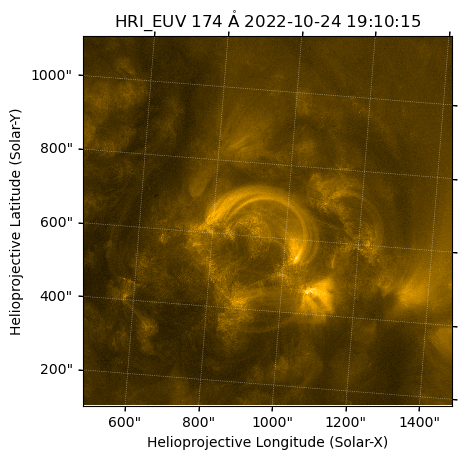

In [16]:
eui_maps[1].plot()

## Lets look at Mar 02 2022 flare

In [78]:
timerange_flare = TimeRange("2022-03-02 00:00", "2022-03-02 23:59")

In [79]:
flare_files = get_eui_filelist(timerange_flare)

In [82]:
len(flare_files)


720

In [84]:
fetch_eui_files(flare_files, timerange_flare)

Files Downloaded:   0%|          | 0/720 [00:00<?, ?file/s]

solo_L3_eui-hrieuv174-image_20220302T000400235_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T000200200_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T000000201_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T000800201_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T000600201_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T001000201_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T001200201_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T001400201_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T001600202_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T001800202_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T002000202_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T002200202_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T002400203_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T002600203_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T002800202_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T003000203_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T003200203_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T003400203_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T003600204_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T003800203_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T004000204_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T004200205_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T004400205_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T004600205_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T004800207_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T005000206_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T005200206_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T005600206_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T005800206_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T005400206_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T010000207_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T010200207_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T010400207_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T010600207_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T010800207_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T011200208_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T011000207_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T011400208_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T011600208_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T011800208_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T012000209_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T012200209_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T012400209_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T012600209_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T012800209_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T013000210_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T013200210_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T013400216_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T013600212_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T013800214_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T014000232_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T014200237_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T014400237_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T014600212_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T014800212_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T015000212_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T015200238_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T015400236_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T015600212_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T015800212_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T020000213_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T020200213_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T020400214_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T020600214_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T020800214_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T021000213_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T021200214_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T021400214_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T021600214_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T021800214_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T022000215_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T022400215_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T022200215_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T022600214_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T022800216_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T023000216_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T023200216_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T023400216_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T023600217_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T023800217_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T024000217_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T024200217_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T024400217_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T024600218_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T024800251_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T025000218_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T025200218_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T025600218_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T025400218_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T025800219_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T030000219_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T030200219_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T030400220_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T030600220_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T031000220_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T030800220_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T031200220_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T031400220_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T031600220_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T031800221_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T032000221_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T032200221_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T032400221_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T032600221_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T032800222_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T033000222_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T033200222_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T033400222_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T033600223_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T033800223_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T034000223_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T034200223_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T034400224_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T034600223_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T034800224_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T035000224_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T035200224_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T035400225_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T035600225_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T040000225_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T035800224_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T040200226_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T040400226_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T040600226_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T040800226_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T041000226_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T041200227_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T041400227_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T041600227_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T041800227_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T042000239_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T042200228_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T042400228_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T042600228_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T042800229_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T043000227_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T043200229_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T043400229_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T043600228_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T043800230_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T044000229_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T044200231_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T044400263_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T044600230_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T044800230_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T045000230_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T045400231_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T045200231_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T045600241_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T045800231_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T050000231_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T050200232_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T050400232_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T050800232_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T051000231_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T051200235_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T051400233_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T050600232_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T051600233_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T052000234_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T051800234_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T052200234_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T052400234_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T052600234_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T052800233_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T053000235_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T053200235_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T053400233_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T053600235_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T053800234_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T054000235_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T054200236_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T054400236_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T054600236_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T054800237_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T055000237_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T055200265_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T055400263_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T055800238_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T055600237_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T060000236_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T060200237_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T060400238_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T060600238_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T060800238_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T061000238_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T061200239_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T061400239_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T061600239_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T061800238_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T062000240_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T062200240_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T062400241_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T062600241_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T062800274_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T063000241_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T063200241_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T063400241_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T063600244_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T063800242_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T064000242_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T064200242_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T064400243_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T064600243_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T064800243_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T065000243_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T065200243_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T065400244_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T065600242_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T065800244_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T070000244_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T070200244_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T070400243_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T070600245_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T071000245_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T070800245_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T071200245_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T071600246_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T071400245_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T071800246_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T072000247_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T072200246_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T072600246_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T072400247_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T073000246_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T072800247_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T073200247_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T073400248_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T073600246_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T073800248_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T074000248_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T074200249_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T074400249_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T074600249_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T074800249_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T075000249_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T075200250_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T075400250_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T075600250_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T075800250_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T080000250_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T080200250_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T080400251_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T080600251_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T080800251_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T081000252_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T081200252_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T081400252_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T081600252_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T081800252_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T082000253_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T082400253_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T082200253_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T082600253_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T082800253_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T083000252_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T083200254_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T083400254_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T083600283_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T083800254_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T084000255_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T084200255_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T084400254_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T084600255_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T084800255_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T085000255_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T085200256_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T085400256_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T085600256_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T085800256_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T090000278_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T090200257_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T090400257_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T090600257_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T090800258_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T091000260_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T091200258_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T091400258_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T091600258_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T091800259_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T092200258_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T092000259_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T092400259_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T092800259_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T093000260_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T093200260_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T093400259_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T093600260_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T093800260_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T094000261_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T094200261_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T094400260_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T094600261_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T094800261_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T095000262_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T095200262_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T095600263_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T095800263_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T095400262_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T100000263_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T100200263_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T100400264_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T100600264_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T100800264_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T101000264_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T101200264_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T101400264_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T101600265_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T101800265_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T102000274_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T102200265_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T102400265_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T102600266_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T092600259_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T102800266_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T103200266_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T103400267_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T103000266_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T103600267_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T103800267_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T104000267_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T104200267_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T104400268_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T104600268_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T104800268_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T105000268_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T105400268_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T105200268_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T105600269_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T105800269_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T110000269_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T110200269_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T110400270_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T110600270_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T110800270_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T111000272_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T111200270_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T111400271_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T111600271_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T111800271_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T112000271_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T112200272_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T112400272_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T112600272_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T112800272_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T113200272_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T113000272_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T113400273_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T113600273_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T113800273_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T114000273_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T114200273_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T114400274_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T114600274_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T114800274_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T115000274_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T115400275_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T115200275_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T115600275_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T115800275_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T120000299_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T120200276_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T120400275_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T120600276_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T120800312_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T121000276_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T121200277_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T121400279_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T121600277_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T121800277_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T122000277_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T122200277_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T122400278_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T122600278_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T122800278_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T123000278_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T123200279_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T123400279_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T123600279_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T123800279_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T124200280_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T124000280_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T124400280_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T124600280_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T124800280_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T125000281_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T125200281_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T125400281_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T125600281_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T125800282_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T130000302_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T130200282_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T130400282_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T130600282_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T130800283_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T131000282_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T131200283_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T131400282_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T131600283_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T131800283_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T132000284_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T132200284_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T132400284_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T132600284_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T132800284_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T133000285_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T133200285_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T133400285_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T133600286_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T133800311_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T134000285_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T134400286_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T134200285_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T134600286_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T134800286_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T135000287_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T135200289_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T135400287_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T135600288_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T135800288_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T140000288_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T140200288_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T140400288_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T140600288_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T141000289_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T140800289_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T141200287_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T141600290_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T141800290_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T141400289_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T142000290_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T142200290_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T142400290_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T142600291_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T142800291_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T143000290_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T143200291_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T143400292_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T143600292_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T143800292_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T144000292_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T144200292_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T144400293_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T144600292_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T144800293_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T145000293_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T145400294_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T145600294_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T145800294_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T145200293_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T150000294_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T150200294_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T150400293_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T150600295_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T150800294_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T151000296_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T151200296_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T151600296_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T151400296_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T152000295_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T152200296_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T151800296_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T152400297_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T153200299_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T152800297_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T152600297_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T153000298_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T153400298_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T153600318_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T153800298_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T154000299_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T154200298_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T154400299_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T154600299_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T154800299_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T155000300_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T155200300_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T155400300_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T155600300_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T155800300_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T160000300_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T160200301_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T160400301_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T160600301_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T161200302_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T160800302_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T161000301_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T161600302_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T161400302_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T162200303_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T161800302_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T162000302_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T162400303_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T162600305_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T162800303_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T163000304_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T163200304_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T163400304_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T163600304_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T163800304_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T164000305_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T164200305_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T164600304_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T164800305_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T164400305_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T165000306_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T165200304_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T165400305_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T165600305_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T165800307_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T170000307_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T170200306_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T170400307_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T170600307_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T170800308_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T171000308_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T171200310_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T171400308_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T171600308_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T171800308_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T172000309_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T172200309_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T172400472_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T172600310_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T172800310_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T173000310_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T173400310_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T173800309_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T173600310_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T173200310_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T174000311_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T174200311_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T174400312_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T174600311_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T174800312_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T175200312_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T175000312_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T175400312_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T175600312_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T175800312_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T180000312_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T180200313_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T180400313_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T180600313_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T180800313_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T181000314_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T181200314_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T181400313_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T181600315_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T182000315_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T181800314_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T182200315_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T182400314_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T182600316_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T182800316_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T183000316_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T183200316_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T183400316_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T183600317_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T183800317_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T184000317_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T184200317_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T184400318_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T184600318_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T184800318_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T185000318_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T185200318_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T185400319_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T185600319_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T185800319_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T190000319_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T190200319_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T190400320_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T190600320_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T190800320_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T191000320_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T191200320_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T191400321_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T191600321_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T191800321_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T192000321_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T192200321_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T192400322_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T192600322_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T192800322_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T193000322_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T193200323_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T193400323_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T193600323_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T193800323_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T194200324_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T194000326_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T194400323_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T194600324_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T194800325_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T195000324_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T195200325_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T195400324_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T195600325_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T195800325_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T200000326_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T200400326_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T200200326_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T200600326_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T201000326_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T200800326_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T201200327_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T201600331_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T201400328_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T201800328_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T202000331_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T202200328_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T202400328_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T202600328_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T203000327_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T202800328_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T203200340_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T203400337_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T203600341_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T203800337_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T204200353_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T204000341_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T204400357_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T204600329_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T204800331_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T205000330_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T205200331_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T205400331_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T205600331_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T205800332_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T210000332_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T210200332_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T210600333_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T210800333_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T210400332_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T211000333_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T211600334_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T211800359_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T212000360_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T211400333_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T211200333_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T212200358_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T212600362_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T212400360_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T212800336_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T213000348_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T213200347_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T213400347_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T213600335_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T213800336_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T214000336_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T214200336_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T214400335_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T214600337_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T214800337_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T215000337_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T215200337_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T215400337_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T215600338_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T215800337_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T220000338_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T220600338_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T220200338_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T220400338_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T220800339_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T221000339_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T221200339_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T221400339_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T221600340_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T221800340_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T222000340_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T222200340_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T222400340_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T222600341_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T222800347_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T223000346_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T223200346_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T223400346_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T223600347_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T223800347_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T224200345_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T224000347_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T224400345_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T224600343_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T225000343_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T224800343_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T225400343_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T225200343_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T225600344_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T225800344_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T230000344_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T230200344_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T230400345_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T230600345_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T230800345_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T231000344_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T231200345_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T231400346_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T231600346_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T231800346_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T232000375_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T232200381_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T232600347_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T232800377_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T233000378_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T232400382_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T233200378_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T233400377_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T233600374_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T233800379_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T234000347_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T234200349_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T234800349_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T234600349_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T235000348_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T234400349_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T235200350_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T235400350_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T235600350_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

solo_L3_eui-hrieuv174-image_20220302T235800350_V02.jp2:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

['eui_files_20220302_0000/solo_L3_eui-hrieuv174-image_20220302T000000201_V02.jp2', 'eui_files_20220302_0000/solo_L3_eui-hrieuv174-image_20220302T000200200_V02.jp2', 'eui_files_20220302_0000/solo_L3_eui-hrieuv174-image_20220302T000400235_V02.jp2', 'eui_files_20220302_0000/solo_L3_eui-hrieuv174-image_20220302T000600201_V02.jp2', 'eui_files_20220302_0000/solo_L3_eui-hrieuv174-image_20220302T000800201_V02.jp2', 'eui_files_20220302_0000/solo_L3_eui-hrieuv174-image_20220302T001000201_V02.jp2', 'eui_files_20220302_0000/solo_L3_eui-hrieuv174-image_20220302T001200201_V02.jp2', 'eui_files_20220302_0000/solo_L3_eui-hrieuv174-image_20220302T001400201_V02.jp2', 'eui_files_20220302_0000/solo_L3_eui-hrieuv174-image_20220302T001600202_V02.jp2', 'eui_files_20220302_0000/solo_L3_eui-hrieuv174-image_20220302T001800202_V02.jp2', 'eui_files_20220302_0000/solo_L3_eui-hrieuv174-image_20220302T002000202_V02.jp2', 'eui_files_20220302_0000/solo_L3_eui-hrieuv174-image_20220302T002200202_V02.jp2', 'eui_files_2022